# Comparison of Set Distances Recorded in 2021

### Cartier vs. Teleost (GULF September Survey)

### Context

In the Andes reports, three different measurements of distance are outputted: 1) The tow distance as manually assessed by CCG personnel (`distance_manual`); 2) the straight-line distance computed between the start and end coordinates of the set (`distance_straight`); and the summed distances of all GPS points collected between the start and end timestamps of the set (`distance_track`).

Historically, our regional Oracle database has been populated with `distance_manual`. Since the use of Andes, the other distance types are readily available in the data exports. Furthermore, the display of the calculated distances on the Bridge Console dashboard has resulted in the CCG personnel copying over the calculated distance, as displayed on the dashboard, into the `distance_manual` field.

In 2021, all three types of distances were recorded and are available for each vessel of the comparative survey (Teleost and Cartier). In 2022, the Cartier excluded the `distance_manual` field from the set card. This resulted in the `distance_straight` variable being used as the "official" measure of set distance (i.e. the values recorded in Oracle).

**Problem:** the comparative technical report being drafted by Gulf Region utilized the `distance_straight` variable for both years. The comparative analysis being written by QC Region used the values from Oracle. As expected there is variation between the different measures of distance.


Unless otherwise noted, distances between points P0 and P1 are calculated with the following function:

```
def calc_nautical_dist(p0, p1):
    """
    p0 and p1 should be dicts with key 'lat' and 'lng'
    """
    nautical_miles = 3443.8985 * math.acos(
        math.sin(p0["lat"] * math.pi / 180) * math.sin(p1["lat"] * math.pi / 180) +
        math.cos(p0["lat"] * math.pi / 180) * math.cos(p1["lat"] * math.pi / 180) *
        math.cos(p1["lng"] * math.pi / 180 - p0["lng"] * math.pi / 180)
    )
    return nautical_miles

```




In [1]:
import math
import re


def calc_nautical_dist(p0, p1):
    """
    p0 and p1 should be dicts with key 'lat' and 'lng'
    """
    nautical_miles = 3443.8985 * math.acos(
        math.sin(p0["lat"] * math.pi / 180) * math.sin(p1["lat"] * math.pi / 180) +
        math.cos(p0["lat"] * math.pi / 180) * math.cos(p1["lat"] * math.pi / 180) *
        math.cos(p1["lng"] * math.pi / 180 - p0["lng"] * math.pi / 180)
    )
    return nautical_miles


def coord_combiner(d, m, longitude=False):
    # always dealing with positive number
    if d < 0:
        d = -d

    if m < 0:
        m = -m

    # peroform the calculations and return
    my_coord = float(d) + float(m) / 60
    if longitude:
        return -my_coord
    else:
        return my_coord


def extract_mission_number(x):
    pattern = """
                (.*\() # junk
                (?P<mission>.*) # bingo
                (\).*) # junk
            """
    mission_search = re.search(pattern, x, re.VERBOSE)
    if mission_search:
        return mission_search.groupdict().get("mission")


def extract_station_number(x):
    pattern = """
                (Station\s) # junk
                (?P<payload>[\d]*) # bingo
                (\s.*) # junk
            """
    mission_search = re.search(pattern, x, re.VERBOSE)
    if mission_search:
        return mission_search.groupdict().get("payload")


In [2]:

import warnings
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


In [3]:
# some common variables to be used

fields_of_interest = ["cruise", "set_number", "start_date", "new_station", "distance_towed", "crow_distance", "track_distance"]
coordinate_fields = ["start_latitude_DD", "start_latitude_MMmm", "start_longitude_DD", "start_longitude_MMmm",
                     "end_latitude_DD", "end_latitude_MMmm", "end_longitude_DD", "end_longitude_MMmm", "set_result", "experiment_type"]
column_rename_map = {
    "distance_towed": "distance_manual",
    "crow_distance": "distance_straight",
    "track_distance": "distance_track",
    "new_station": "station_number",

}

In [31]:
# TELEOST IMPORT

# let's start by grabbing the data frame
df_tel = pd.read_csv("./data/TEL_set_data.csv")
df_car = pd.read_csv("./data/CAR_set_data.csv")

df = pd.concat([df_tel, df_car], ignore_index=True)


df = df.loc[:, fields_of_interest + coordinate_fields]
df.rename(columns=column_rename_map, inplace=True)
df["cruise"] = df["cruise"].apply(lambda x: extract_mission_number(x))
df["station_number"] = df["station_number"].apply(lambda x: extract_station_number(x))
df["start_date"] = pd.to_datetime(df["start_date"].apply(lambda x: x.split(".")[0].split("+")[0]), format="%Y-%m-%d %H:%M:%S")
df["start"] = df.apply(lambda x: {"lat": coord_combiner(x["start_latitude_DD"], x["start_latitude_MMmm"]),
                                          "lng": coord_combiner(x["start_longitude_DD"], x["start_longitude_MMmm"])}, axis=1)
df["end"] = df.apply(lambda x: {"lat": coord_combiner(x["end_latitude_DD"], x["end_latitude_MMmm"]),
                                        "lng": coord_combiner(x["end_longitude_DD"], x["end_longitude_MMmm"])}, axis=1)
df.drop(columns=coordinate_fields)
df.sort_values("start_date", inplace=True)

color_map = {
    "TEL-2021-221": "red",
    "CJC-2021-222": "blue",
}
df["color"] = df["cruise"].map(color_map)

# lets keep only NORMAL sets
mask = df["set_result"].str.contains("NORMAL")
df = df.where(mask).dropna()
# lets keep only NORMAL sets
mask = df["experiment_type"].str.contains("Hydro") == False
df = df.where(mask).dropna()

df

,cruise,set_number,start_date,station_number,distance_manual,distance_straight,distance_track,start_latitude_DD,start_latitude_MMmm,start_longitude_DD,start_longitude_MMmm,end_latitude_DD,end_latitude_MMmm,end_longitude_DD,end_longitude_MMmm,set_result,experiment_type,start,end,color
0,TEL-2021-221,1.0,2021-08-28 22:08:13,037,1.74,1.75,1.74,47.0,45.7069,-65.0,35.4487,47.0,44.1884,-65.0,34.1755,1 - NORMAL - No damage to gear,1 - Stratified random survey set,"{'lat': 47.761781666666664, 'lng': 65.59081166...","{'lat': 47.736473333333336, 'lng': 65.56959166...",red
1,TEL-2021-221,2.0,2021-08-29 00:50:18,036,1.76,1.76,1.75,47.0,50.7540,-65.0,16.8459,47.0,51.3150,-65.0,14.3712,1 - NORMAL - No damage to gear,1 - Stratified random survey set,"{'lat': 47.8459, 'lng': 65.280765}","{'lat': 47.85525, 'lng': 65.23952}",red
2,TEL-2021-221,3.0,2021-08-29 02:42:49,035,1.75,1.75,1.75,47.0,53.7340,-65.0,4.0007,47.0,54.4384,-65.0,1.6233,1 - NORMAL - No damage to gear,1 - Stratified random survey set,"{'lat': 47.89556666666667, 'lng': 65.066678333...","{'lat': 47.90730666666666, 'lng': 65.027055}",red
3,TEL-2021-221,4.0,2021-08-29 06:40:14,033,1.77,1.76,1.75,48.0,7.3119,-64.0,33.5282,48.0,7.8900,-64.0,36.0115,1 - NORMAL - No damage to gear,1 - Stratified random survey set,"{'lat': 48.121865, 'lng': 64.55880333333333}","{'lat': 48.1315, 'lng': 64.60019166666666}",red
4,TEL-2021-221,5.0,2021-08-29 08:46:21,031,1.77,1.77,1.76,48.0,15.4413,-64.0,26.9784,48.0,16.7468,-64.0,25.1984,1 - NORMAL - No damage to gear,1 - Stratified random survey set,"{'lat': 48.257355, 'lng': 64.44964}","{'lat': 48.279113333333335, 'lng': 64.41997333...",red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CJC-2021-222,161.0,2021-09-26 20:52:06,006,1.09,1.04,1.03,46.0,3.3870,-63.0,11.1620,46.0,2.7690,-63.0,9.9560,1 - NORMAL - No damage to gear,5 - Comparative fishing experiment,"{'lat': 46.05645, 'lng': 63.186033333333334}","{'lat': 46.04615, 'lng': 63.165933333333335}",blue
184,TEL-2021-221,185.0,2021-09-26 22:51:57,181,1.70,1.84,1.79,45.0,58.7332,-63.0,10.1836,45.0,58.8394,-63.0,7.5463,1 - NORMAL - No damage to gear,1 - Stratified random survey set,"{'lat': 45.97888666666667, 'lng': 63.169726666...","{'lat': 45.98065666666667, 'lng': 63.125771666...",red
347,CJC-2021-222,162.0,2021-09-26 22:55:27,181,1.09,1.04,0.99,45.0,59.2510,-63.0,9.8800,45.0,59.3230,-63.0,8.3940,1 - NORMAL - No damage to gear,5 - Comparative fishing experiment,"{'lat': 45.987516666666664, 'lng': 63.16466666...","{'lat': 45.98871666666667, 'lng': 63.1399}",blue
185,TEL-2021-221,186.0,2021-09-27 01:23:10,340,1.70,1.79,1.75,45.0,56.3561,-63.0,1.2050,45.0,57.3162,-63.0,3.3745,1 - NORMAL - No damage to gear,1 - Stratified random survey set,"{'lat': 45.93926833333333, 'lng': 63.020083333...","{'lat': 45.955270000000006, 'lng': 63.05624166...",red


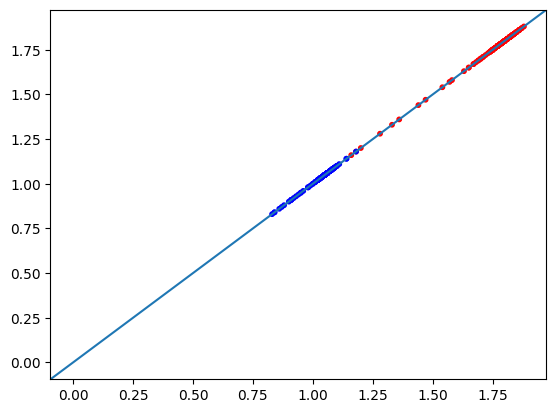

In [35]:
# let's recalculate the `distance_straight` here so we are sure that this is in fact what the set report has provided us with
df["distance_straight_2"] = df.apply(lambda x: round(calc_nautical_dist(x.start, x.end), 2), axis=1)
x = df.apply(lambda x: x["distance_straight"] == x["distance_straight_2"], axis=1)
assert pd.Series.sum(x == False) == 0, "Some of the calculated distances do not jive with the values on the set report"
fig, ax = plt.subplots()
plt.scatter(df["distance_straight"], df["distance_straight_2"], c=df["color"], s=10)
ax.axline((0, 0), slope=1)

Great, so we can be confident that the data found in the `distance_straigh` col matches up with the distance between the start and end coordinates

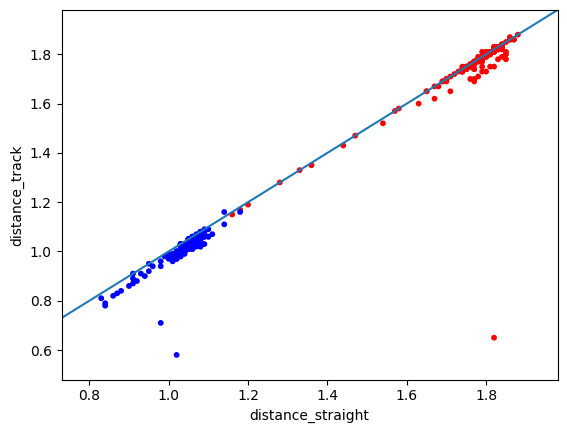

In [27]:
# let's start with less controversial... look at difference between `distance_straight` and `distance_track`
fig, ax = plt.subplots()
plt.scatter(df["distance_straight"], df["distance_track"], c=df["color"], s=10)
plt.xlabel("distance_straight")
plt.xlim(df["distance_straight"].min()-0.1, df["distance_straight"].max()+0.1)
plt.ylim(df["distance_track"].min()-0.1, df["distance_track"].max()+0.1)
plt.ylabel("distance_track")
ax.axline((0, 0), slope=1)


They are very similar but the track distance seems to be less reliable. It is a bit of a mystery why that is. Perhaps Andes stopped recording GPS coorindates at certain points?

This is a good reason for favoring the straight line distance over the track distance.

In [29]:
x = df["distance_straight"] - df["distance_track"]
x.mean()

0.023780918727915205

Another puzzle is why the mean different between the track distance and straight line difference is slightly positive. It really should be the other way around. It would be nice to look at other years and to revisit the code for how the track distance is being calculated.

But onto more pressing matters...

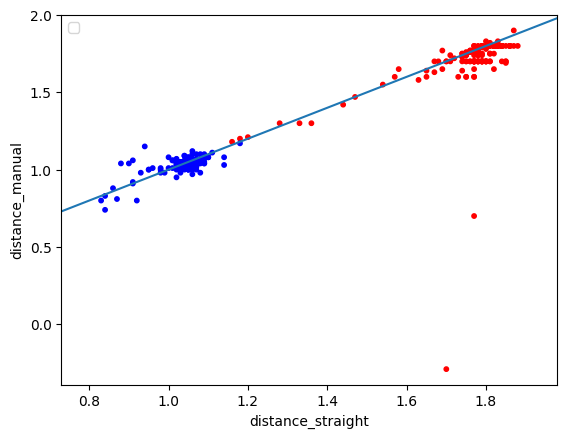

In [45]:
fig, ax = plt.subplots()
plt.scatter(df["distance_straight"], df["distance_manual"], c=df["color"], s=10)
plt.xlabel("distance_straight")
plt.xlim(df["distance_straight"].min()-0.1, df["distance_straight"].max()+0.1)
plt.ylim(df["distance_manual"].min()-0.1, df["distance_manual"].max()+0.1)
plt.ylabel("distance_manual")
ax.legend(['First line', 'Second line'], ['red',2])
ax.axline((0, 0), slope=1)